## Feature Engineering work

In [1]:
## Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', 100)

In [2]:
## Reading the data set
train = pd.read_csv('/Users/EvanCallaghan/Documents/Courses/Predictive Analytics/DATA-448-Project/Data/diabetes_train.csv')

## Printing the first five observations
train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_012
0,0.0,1.0,1.0,30.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,30.0,5.0,0.0,0.0,6.0,6.0,8.0,2.0
1,1.0,1.0,1.0,30.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,11.0,4.0,7.0,0.0
2,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,6.0,7.0,0.0
3,1.0,1.0,1.0,24.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,4.0,0.0,1.0,7.0,5.0,7.0,0.0
4,0.0,0.0,1.0,35.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,7.0,4.0,1.0,0.0


### Exploration

In [ ]:
plt.hist(train['BMI'], bins = 20)

In [ ]:
plt.hist(train['GenHlth'], bins = 5)

In [ ]:
plt.hist(train['MentHlth'], bins = 30)

In [ ]:
plt.hist(train['PhysHlth'], bins = 30)

In [ ]:
plt.hist(train['Age'], bins = 8, edgecolor = 'black')

In [ ]:
plt.hist(train['Education'], bins = 6)

In [ ]:
plt.hist(train['Income'], bins = 8)

### Feature Engineering

In [3]:
## BMI Categoricals

train['BMI_Underweight'] = np.where(train['BMI'] < 18.5, 1, 0)
train['BMI_Healthy'] = np.where((train['BMI'] >= 18.5) & (train['BMI'] < 25), 1, 0)
train['BMI_Overweight'] = np.where((train['BMI'] >= 25) & (train['BMI'] < 30), 1, 0)
train['BMI_Obese'] = np.where(train['BMI'] >= 30, 1, 0)


## Log(BMI)
train['Log_BMI'] = np.log(train['BMI'])


## Creating dummy variables for Sex, Education, and Income

train = pd.concat([train.drop(columns = ['Sex']), pd.get_dummies(train['Sex'])], axis = 1)
train = train.rename(columns = { 0: 'Female', 1: 'Male'})

train = pd.concat([train.drop(columns = ['Education']), pd.get_dummies(train['Education'])], axis = 1)
train = train.rename(columns = { 1: 'Never_Attended', 2: 'Grades_1_8', 3: 'Grades_9_11', 4: 'GED', 5: 'College_1_3', 
                              6: 'College_4+'})

train = pd.concat([train.drop(columns = ['Income']), pd.get_dummies(train['Income'])], axis = 1)
train = train.rename(columns = { 1: '<10,000', 2: '<15,000', 3: '<20,000', 4: '<25,000', 5: '<35,000', 
                                      6: '<50,000',  7: '<75,000',  8: '75,000+'})


## Fruits and Veggies
train['Fruits+Veggies'] = np.where((train['Fruits'] == 1) & (train['Veggies'] == 1), 1, 0)

## Health care issues
train['HealthCareIssues'] = np.where((train['AnyHealthcare'] == 0) & (train['NoDocbcCost'] == 0), 1, 0)

## Poor diet
train['PoorDiet'] = np.where((train['Fruits'] == 0) & (train['Veggies'] == 0) & 
                                (train['HvyAlcoholConsump'] == 1), 1, 0)


train['MentHlth_cat'] = np.where((train.MentHlth <=10), 0, 
                                 np.where((train.MentHlth > 10) & (train.MentHlth <= 20), 1, 2))

train['PhysHlth_cat'] = np.where((train.PhysHlth <=10), 0, 
                              np.where((train.PhysHlth > 10) & (train.PhysHlth <= 20), 1, 2))

train['GenHlth_cat'] = np.where((train.GenHlth <=2), 0, 
                             np.where((train.GenHlth > 3) & (train.GenHlth <= 5), 1, 2))

In [5]:
## Calculating variable importance scores

## Defining the input and target variables
X = train.drop(columns = ['Diabetes_012'])
Y = train['Diabetes_012']

## Defining a list to store results
results = []

## Repeating process 100 times
for i in tqdm(range(0, 25)):
    
    ## Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    ## Building the model
    OneVsRest_md = OneVsRestClassifier(estimator = RandomForestClassifier(max_depth = 3, 
                                                                   n_estimators = 500)).fit(X_train, Y_train)
    
    ## Appending feature importance results
    for md in OneVsRest_md.estimators_:
        
        ## Extracting the scores from each model
        results.append(md.feature_importances_)

    

## Changing results list to a dataframe
results = pd.DataFrame(results, columns = X.columns)

## Computing averages and sorting variables by importance
results = pd.DataFrame(results.apply(np.mean, axis = 0))
results = pd.DataFrame({'Feature': results.index, 'Importance': results[0].values}).sort_values(by = 'Importance', ascending = False)

## Printing the 10 most important variables
results.head(10)

100%|██████████| 25/25 [24:22<00:00, 58.51s/it]


,Feature,Importance
0,HighBP,0.164299
13,GenHlth,0.141154
44,GenHlth_cat,0.136300
1,HighChol,0.090789
22,Log_BMI,0.078797
3,BMI,0.077984
16,DiffWalk,0.063898
21,BMI_Obese,0.059546
17,Age,0.045350
6,HeartDiseaseorAttack,0.025912


In [6]:
## Creating interactions

train['Interaction_1'] = train['HighBP'] * train['GenHlth']

train['Interaction_2'] = train['HighBP'] * train['GenHlth_cat']

train['Interaction_3'] = train['HighBP'] * train['HighChol']

train['Interaction_4'] = train['GenHlth'] * train['GenHlth_cat']

train['Interaction_5'] = train['GenHlth'] * train['HighChol']

train['Interaction_6'] = train['GenHlth_cat'] * train['HighChol']

[Text(558.0, 951.3000000000001, 'Interaction_2 <= 0.5\ngini = 0.271\nsamples = 142060\nvalue = [119673, 2593, 19794]'),
 Text(279.0, 679.5, 'Interaction_5 <= 1.5\ngini = 0.162\nsamples = 104161\nvalue = [95041, 1410, 7710]'),
 Text(139.5, 407.70000000000005, 'Age <= 8.5\ngini = 0.113\nsamples = 74848\nvalue = [70395, 713, 3740]'),
 Text(69.75, 135.89999999999998, 'gini = 0.068\nsamples = 47429\nvalue = [45771, 304, 1354]'),
 Text(209.25, 135.89999999999998, 'gini = 0.186\nsamples = 27419\nvalue = [24624, 409, 2386]'),
 Text(418.5, 407.70000000000005, 'Log_BMI <= 3.384\ngini = 0.274\nsamples = 29313\nvalue = [24646, 697, 3970]'),
 Text(348.75, 135.89999999999998, 'gini = 0.216\nsamples = 19071\nvalue = [16771, 371, 1929]'),
 Text(488.25, 135.89999999999998, 'gini = 0.368\nsamples = 10242\nvalue = [7875, 326, 2041]'),
 Text(837.0, 679.5, 'Interaction_5 <= 3.5\ngini = 0.475\nsamples = 37899\nvalue = [24632, 1183, 12084]'),
 Text(697.5, 407.70000000000005, 'BMI <= 30.5\ngini = 0.43\nsample

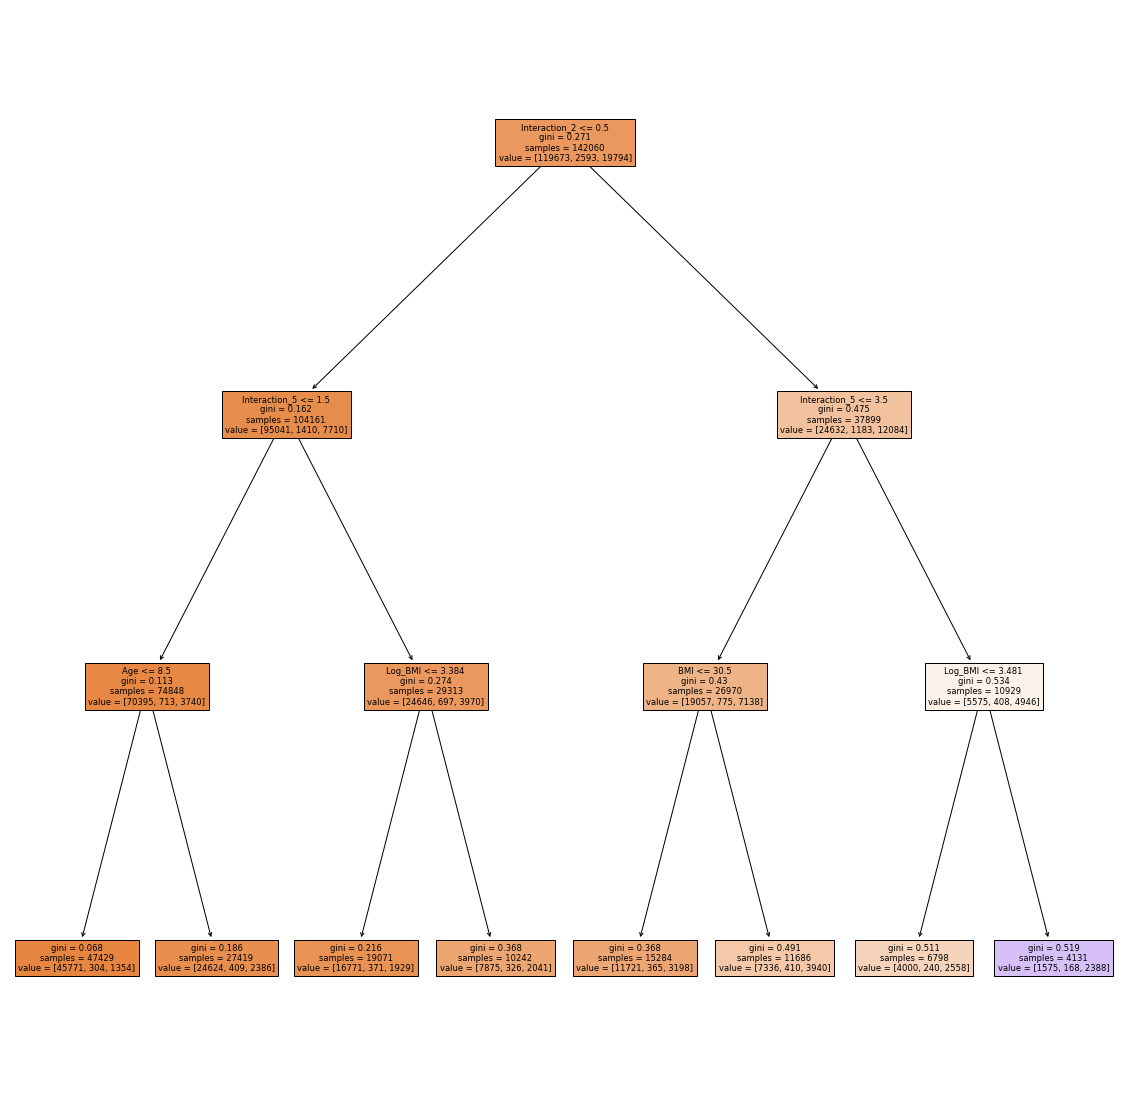

In [8]:
## Creating a plot tree to engineer more interactions

## Defining the input and target variables
X = train.drop(columns = ['Diabetes_012'])
Y = train['Diabetes_012']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y)

## Building a decision tree model with max depth = 3 on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 20))
plot_tree(tree_md, feature_names = X.columns, filled = True)

In [9]:
## Creating tree interactions

train['Tree_1'] = np.where((train['Interaction_2'] <= 0.5) & (train['Interaction_5'] <= 1.5) & (train['Age'] <= 8.5), 1, 0)

train['Tree_2'] = np.where((train['Interaction_2'] <= 0.5) & (train['Interaction_5'] <= 1.5) & (train['Age'] > 8.5), 1, 0)

train['Tree_3'] = np.where((train['Interaction_2'] <= 0.5) & (train['Interaction_5'] > 1.5) & (train['Log_BMI'] <= 3.384), 1, 0)

train['Tree_4'] = np.where((train['Interaction_2'] <= 0.5) & (train['Interaction_5'] > 1.5) & (train['Log_BMI'] > 3.384), 1, 0)

train['Tree_5'] = np.where((train['Interaction_2'] > 0.5) & (train['Interaction_5'] <= 3.5) & (train['BMI'] <= 30.5), 1, 0)

train['Tree_6'] = np.where((train['Interaction_2'] > 0.5) & (train['Interaction_5'] <= 3.5) & (train['BMI'] > 30.5), 1, 0)

train['Tree_7'] = np.where((train['Interaction_2'] > 0.5) & (train['Interaction_5'] > 3.5) & (train['Log_BMI'] <= 3.481), 1, 0)

train['Tree_8'] = np.where((train['Interaction_2'] > 0.5) & (train['Interaction_5'] > 3.5) & (train['Log_BMI'] > 3.481), 1, 0)

In [10]:
train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Diabetes_012,BMI_Underweight,BMI_Healthy,BMI_Overweight,BMI_Obese,Log_BMI,Female,Male,Grades_1_8,2.0,Grades_9_11,GED,College_1_3,College_4+,"<15,000",2.0,"<20,000","<25,000","<35,000","75,000+","<75,000",8.0,Fruits+Veggies,HealthCareIssues,PoorDiet,MentHlth_cat,PhysHlth_cat,GenHlth_cat,Interaction_1,Interaction_2,Interaction_3,Interaction_4,Interaction_5,Interaction_6,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8
0,0.0,1.0,1.0,30.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,30.0,5.0,0.0,6.0,2.0,0,0,0,1,3.401197,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,2,0,0,0.0,0.0,0.0,0.0,2.0,0.0,0,0,0,1,0,0,0,0
1,1.0,1.0,1.0,30.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,11.0,0.0,0,0,0,1,3.401197,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2.0,0.0,1.0,0.0,2.0,0.0,0,0,0,1,0,0,0,0
2,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,8.0,0.0,0,0,1,0,3.258097,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0
3,1.0,1.0,1.0,24.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,4.0,0.0,7.0,0.0,0,1,0,0,3.178054,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2,3.0,2.0,1.0,6.0,3.0,2.0,0,0,0,0,1,0,0,0
4,0.0,0.0,1.0,35.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,7.0,0.0,0,0,0,1,3.555348,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,4.0,0.0,0.0,1,0,0,0,0,0,0,0


In [11]:
train.shape

(202944, 60)